In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats

from get_data import *
from get_financial_data import *

plt.rcParams['figure.dpi'] = 200

In [2]:
from_height, to_height = 630000, 705000

In [3]:
block_data = pd.read_csv(f"data_btc/blocks_{from_height}_{to_height}.csv", index_col=0)

block_data['time_diff'] = [b-a for a,b in zip(block_data['time'][:-1], block_data['time'][1:])] + [0]
block_data['date'] = pd.to_datetime(block_data['time'], unit='s')
block_data['hash'] = block_data['hash'].astype(float)
block_data['bits'] = (1/(block_data['bits'] * 2**(8*(0x1b - 3)))).astype(float)

print(block_data.columns)

Index(['hash', 'ver', 'time', 'bits', 'fee', 'nonce', 'n_tx', 'difficulty',
       'vin_sz_count', 'vin_sz_mean', 'vin_sz_std', 'vin_sz_min', 'vin_sz_max',
       'vout_sz_count', 'vout_sz_mean', 'vout_sz_std', 'vout_sz_min',
       'vout_sz_max', 'fee_count', 'fee_mean', 'fee_std', 'fee_min', 'fee_max',
       'lock_time_count', 'lock_time_mean', 'lock_time_std', 'lock_time_min',
       'lock_time_max', 'value_count', 'value_mean', 'value_std', 'value_min',
       'value_max', 'time_diff', 'date'],
      dtype='object')


# Finding the nonce

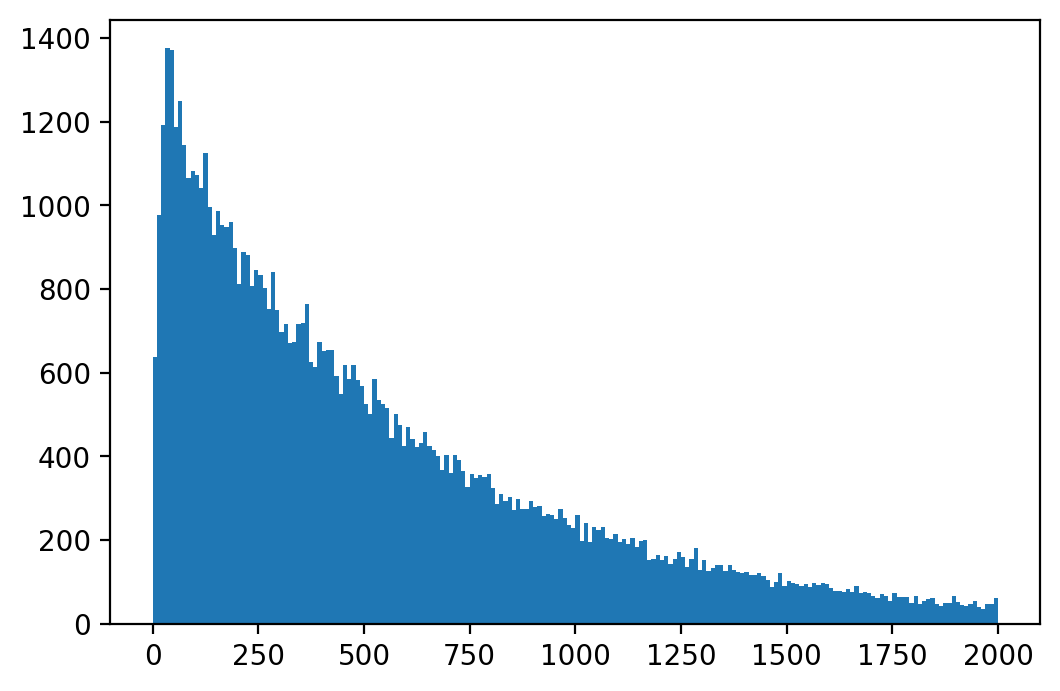

In [4]:
plt.hist(block_data["time_diff"], bins=200, range=(0,2000))
#plt.xscale("log")
plt.show()

(0.0, 8867.25)

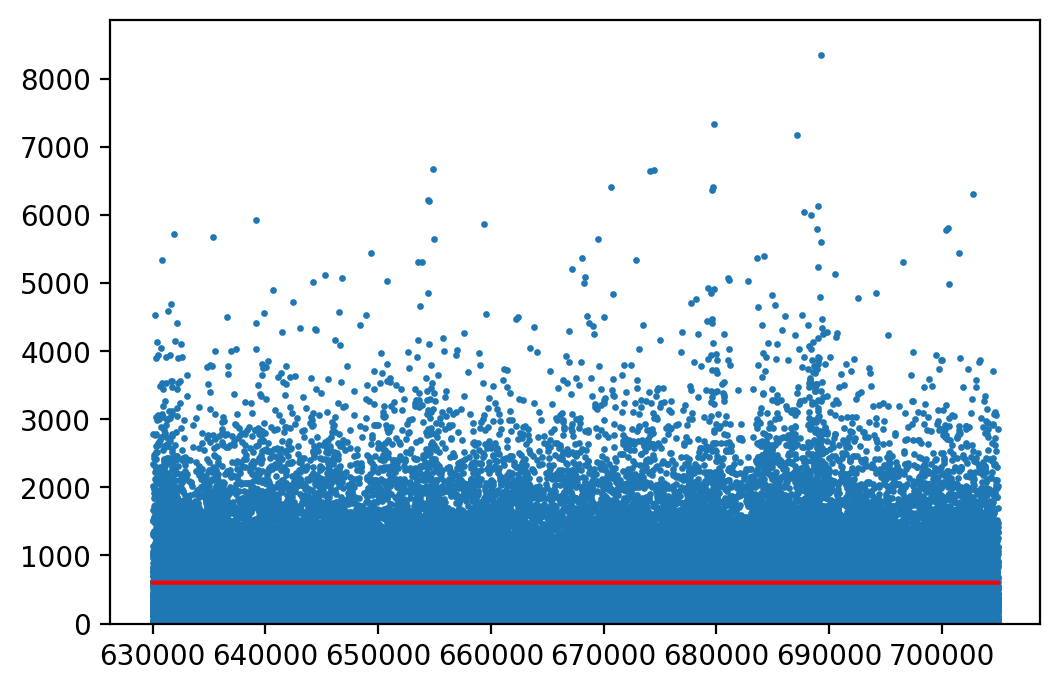

In [5]:
plt.scatter(block_data.index, block_data["time_diff"], s=2)
plt.plot(block_data.index, [10*60 for _ in block_data.index], c='r')
#plt.yscale("log")
plt.ylim(bottom=0)

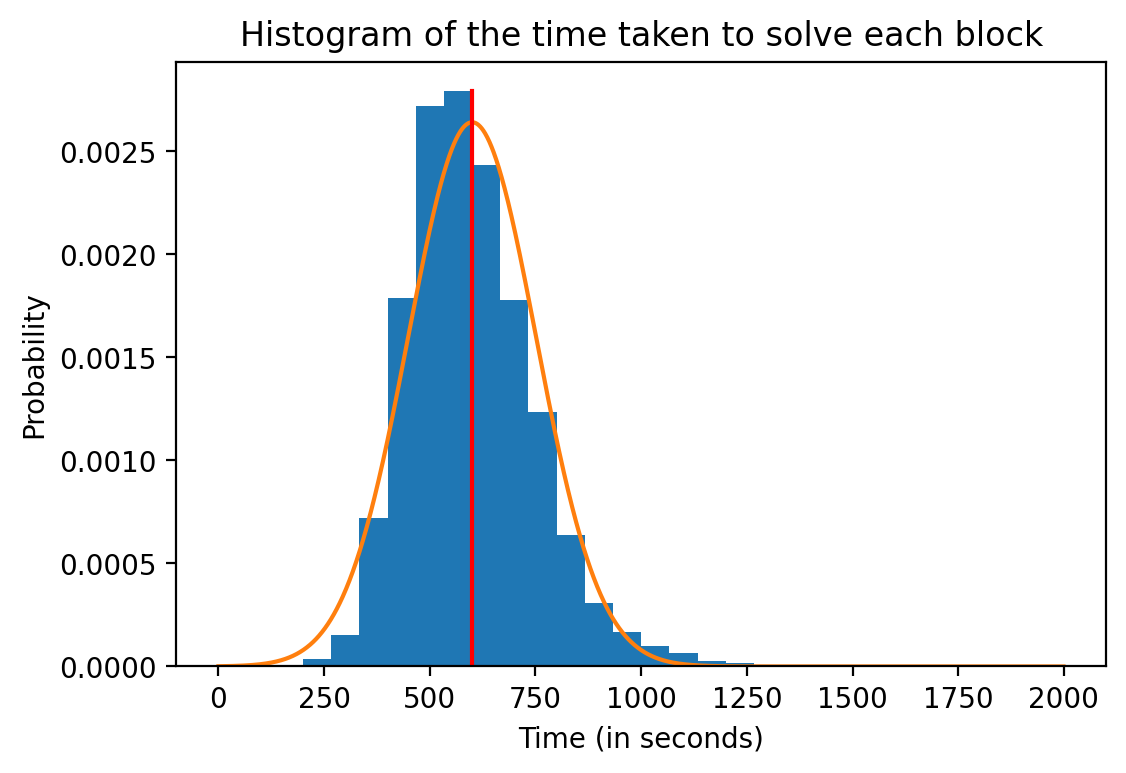

In [6]:
grouped_time_diff = block_data["time_diff"].groupby(np.arange(len(block_data))//20).mean()
columns, x, _ = plt.hist(grouped_time_diff, bins=30, range=(0,2000), density=True)

mean = grouped_time_diff.mean()
std  = grouped_time_diff.std()
#x = np.linspace(0, 2000, 1000)
plt.plot(range(int(x.max())), stats.norm.pdf(range(int(x.max())), mean, std))

#plt.xscale("log")
plt.plot([600,600],[0,columns.max()],c='r')

plt.title('Histogram of the time taken to solve each block')
plt.xlabel('Time (in seconds)')
plt.ylabel('Probability')

plt.show()

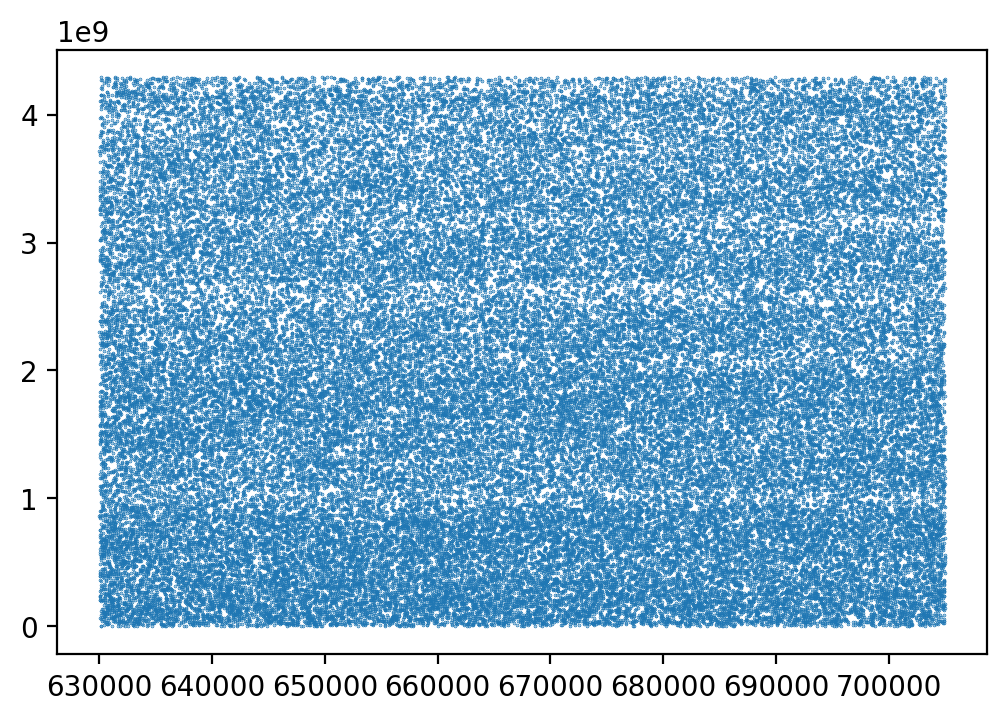

In [7]:
plt.scatter(block_data.index, block_data['nonce'], s=.07)

Text(0.5, 0, 'Nonce value')

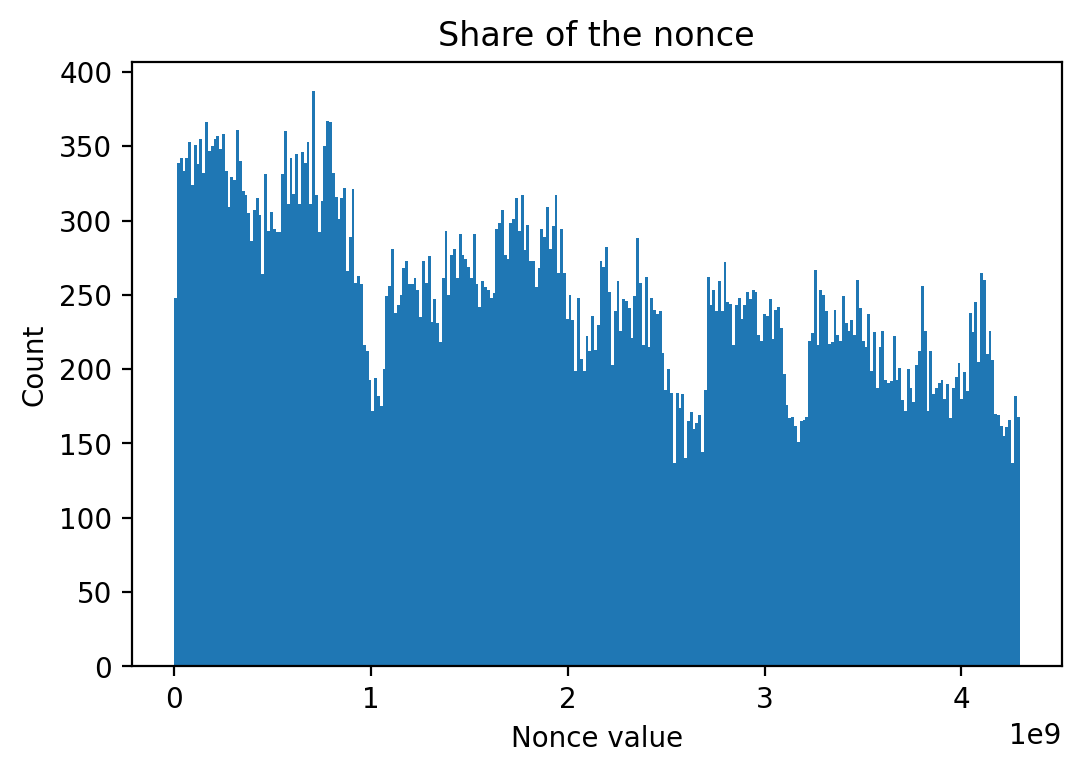

In [16]:
plt.hist(block_data['nonce'], bins=300)#, density=True)
plt.title('Share of the nonce')
plt.ylabel('Count')
plt.xlabel('Nonce value')

# A correlation with the price

In [9]:
financial = get_ticker_data('btc-usd')

financial['time'] = financial['date'].apply(lambda x: x.value)
financial.drop(inplace=True, index=np.where(financial['date']<block_data['date'][block_data.index[0]])[0])
financial.reset_index(inplace=True)
financial.drop(inplace=True, index=np.where(financial['date']>block_data['date'][block_data.index[-1]])[0])

Shape of DataFrame:  (2603, 7)


In [10]:
def plot_with_financial(col, title='Correlation graph', ylabel=''):
    grouped = block_data.groupby(np.arange(len(block_data))//500).mean()
    grouped = grouped.dropna()
    grouped['date'] = pd.to_datetime(grouped['time'], unit='s', utc=True)

    fig,ax=plt.subplots(dpi=200)
    ax.set_title(title)

    f = financial.groupby(np.arange(len(financial))//2).mean()
    f['date'] = pd.to_datetime(f['time'])
    ax.plot(f['date'], f['close'], color='purple', linewidth=2)
    ax.set_xlabel('Date', fontsize=13)
    ax.tick_params(axis='x', labelrotation=45)
    ax.set_ylabel("BTC Value (USD)", color='purple', fontsize=13)

    ax2=ax.twinx()
    ax2.plot(grouped['date'], grouped[col], color='blue', alpha=.8)
    ax2.set_ylabel(ylabel, color='blue',fontsize=13)

    #plt.show()

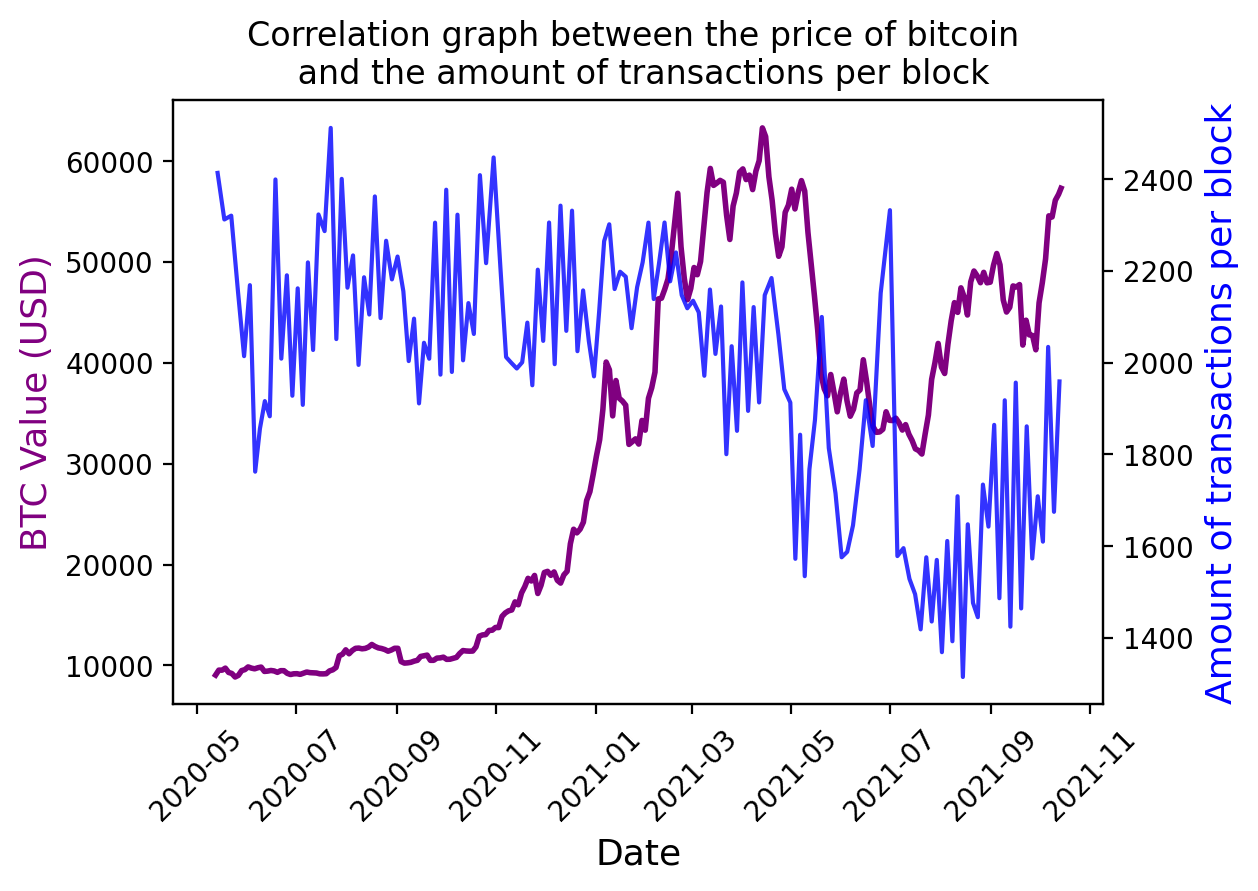

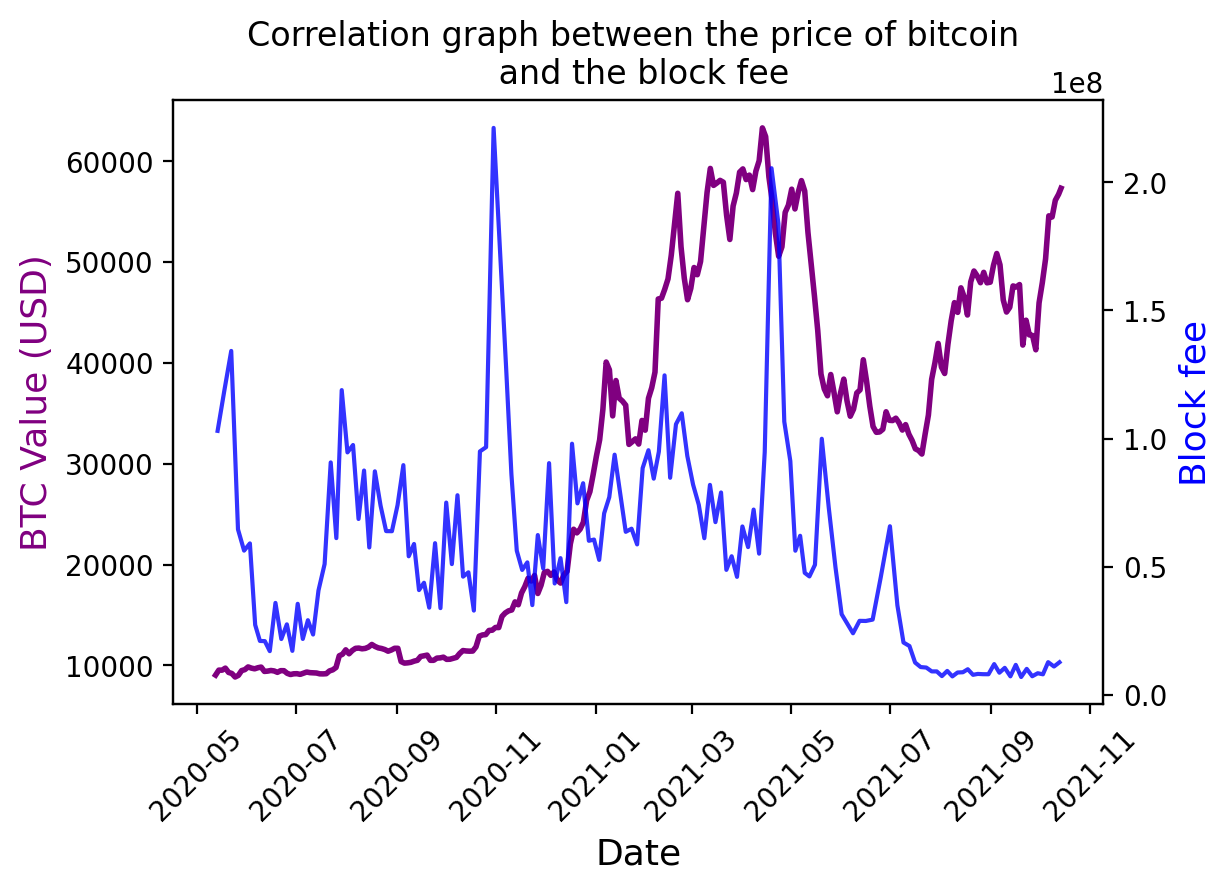

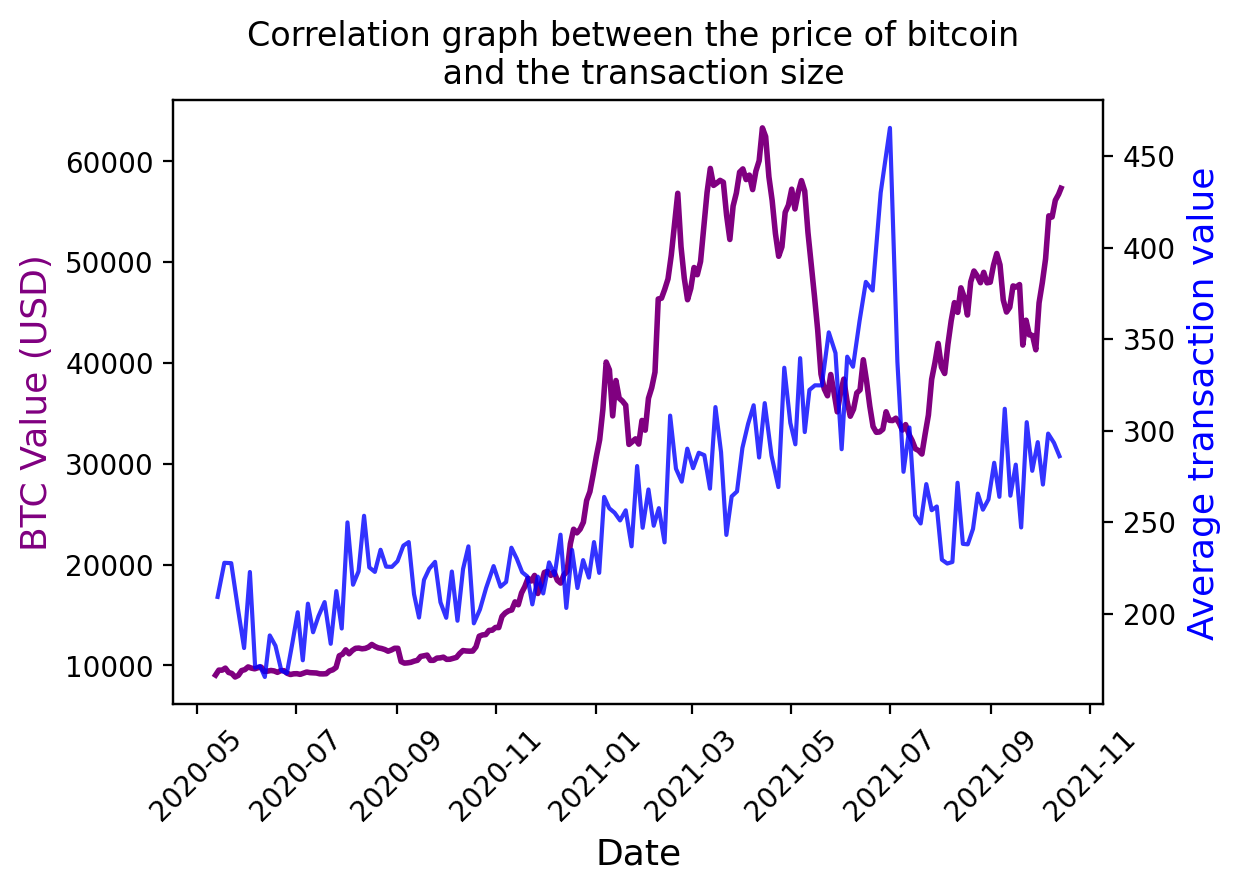

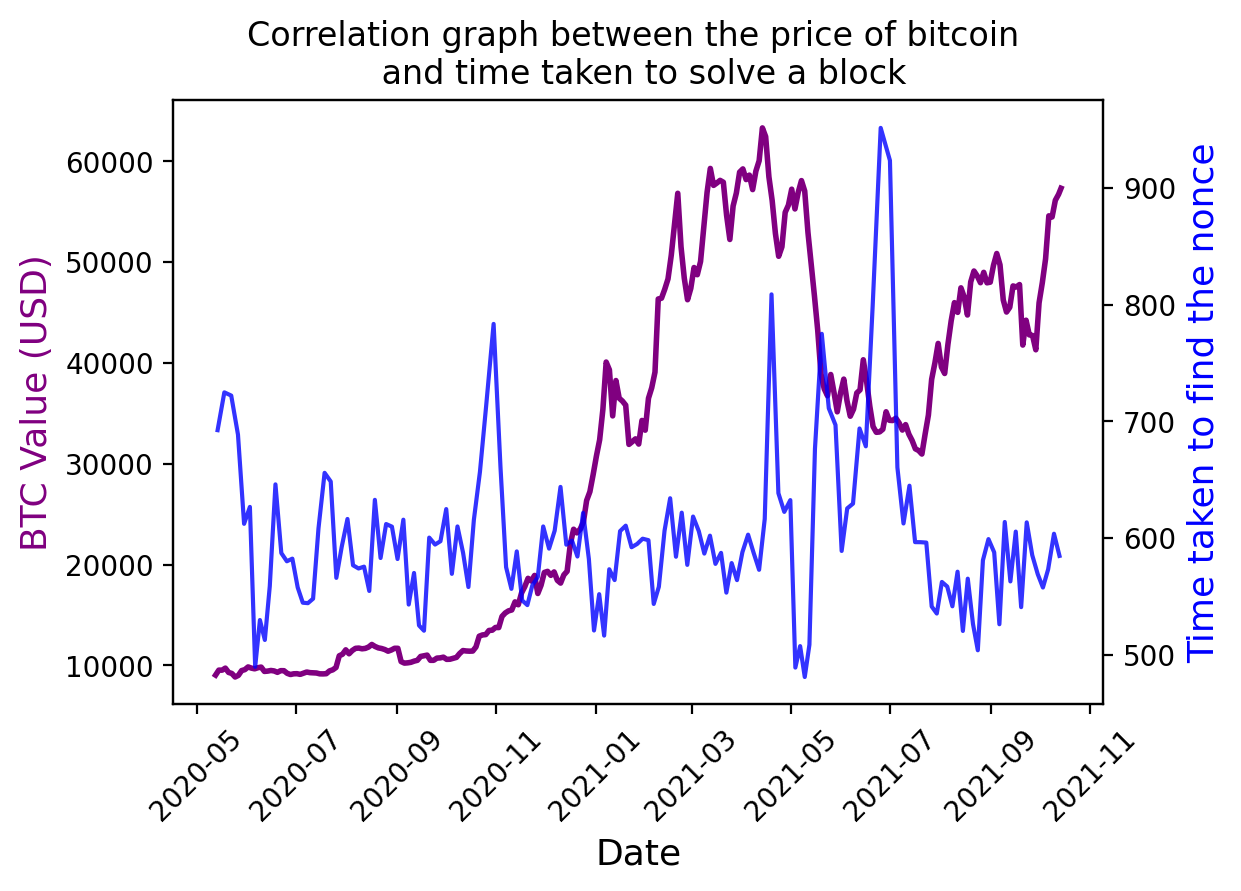

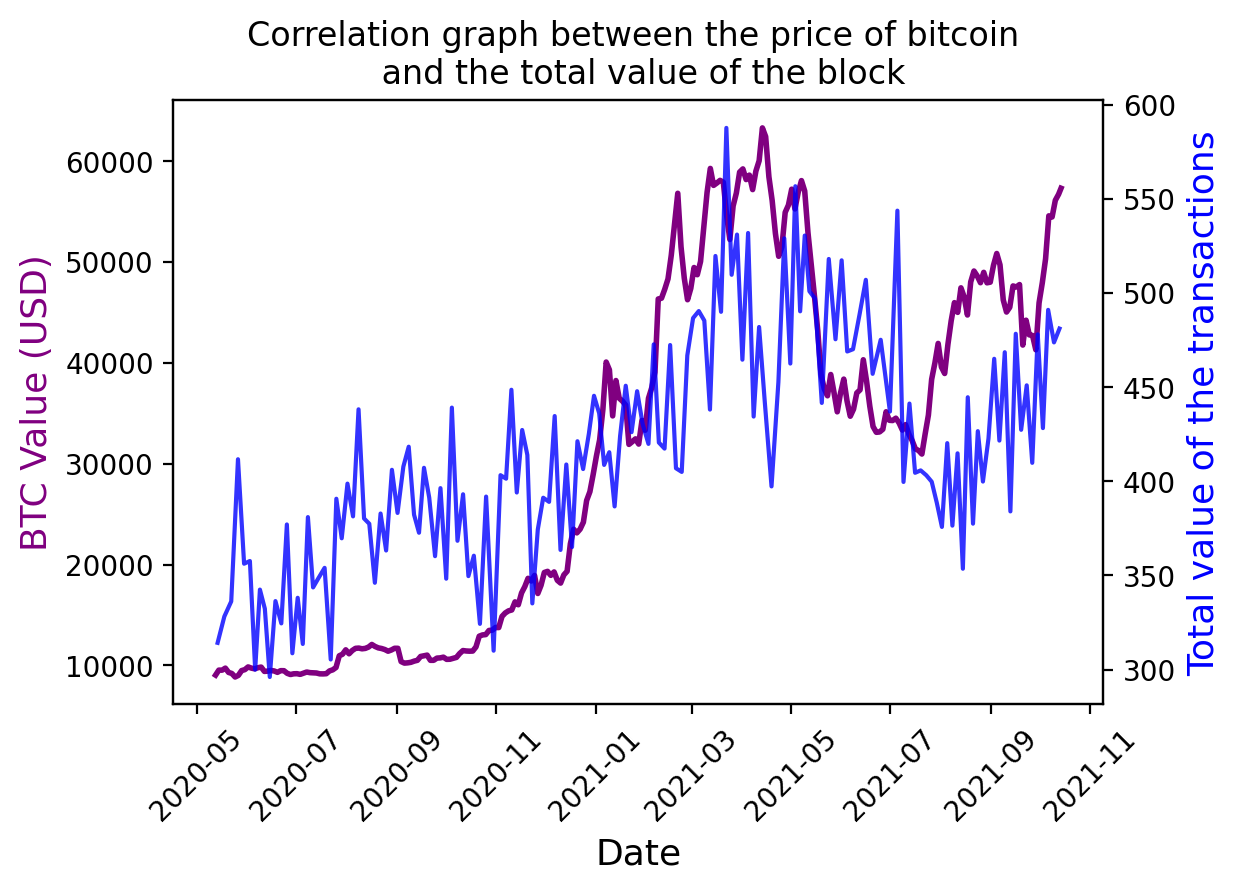

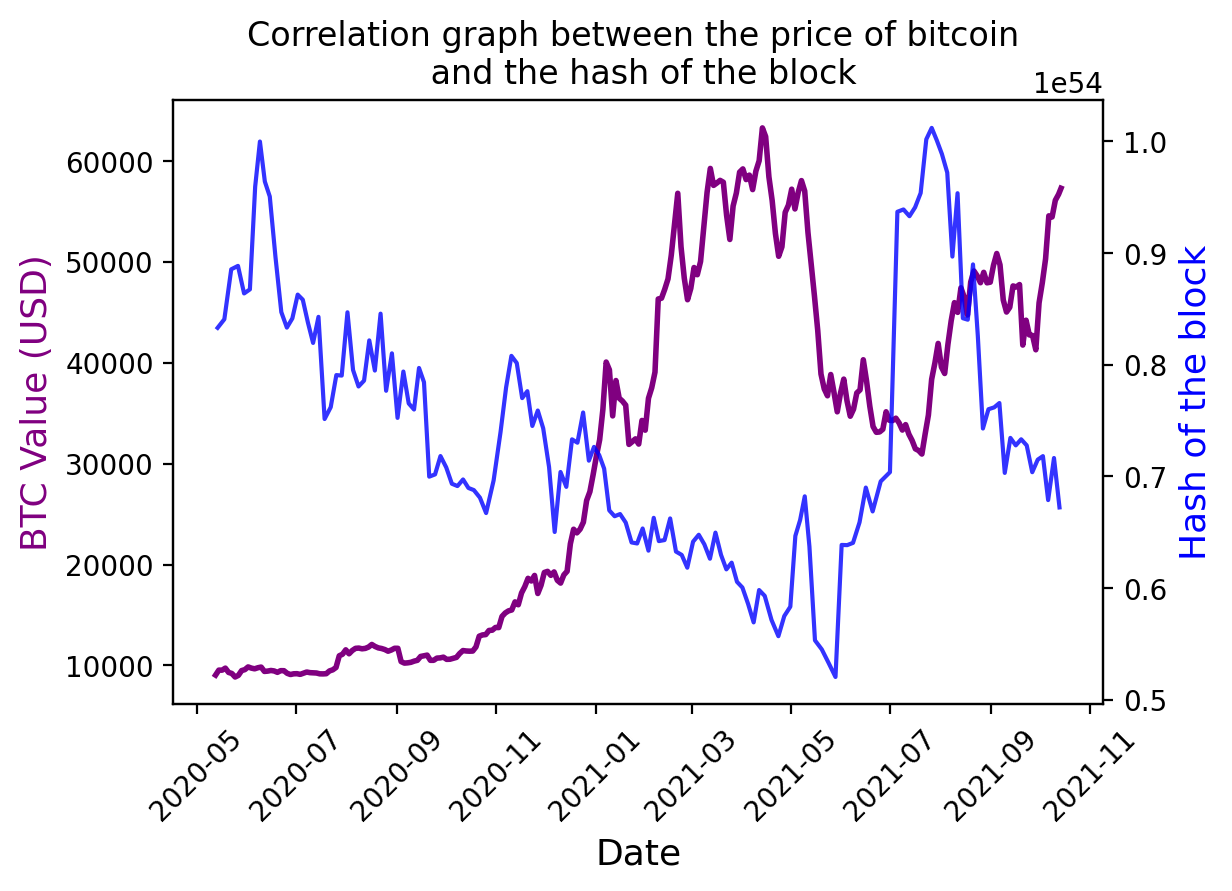

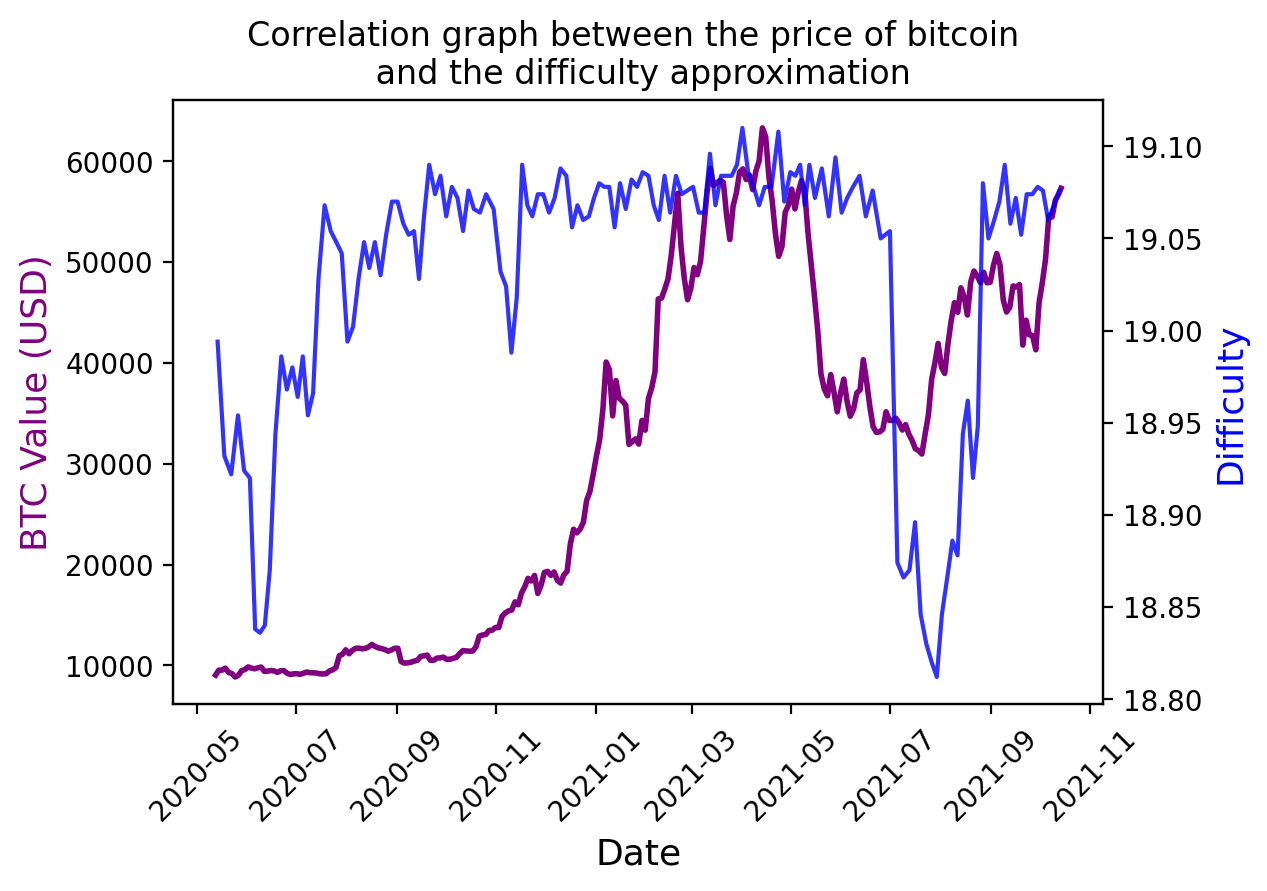

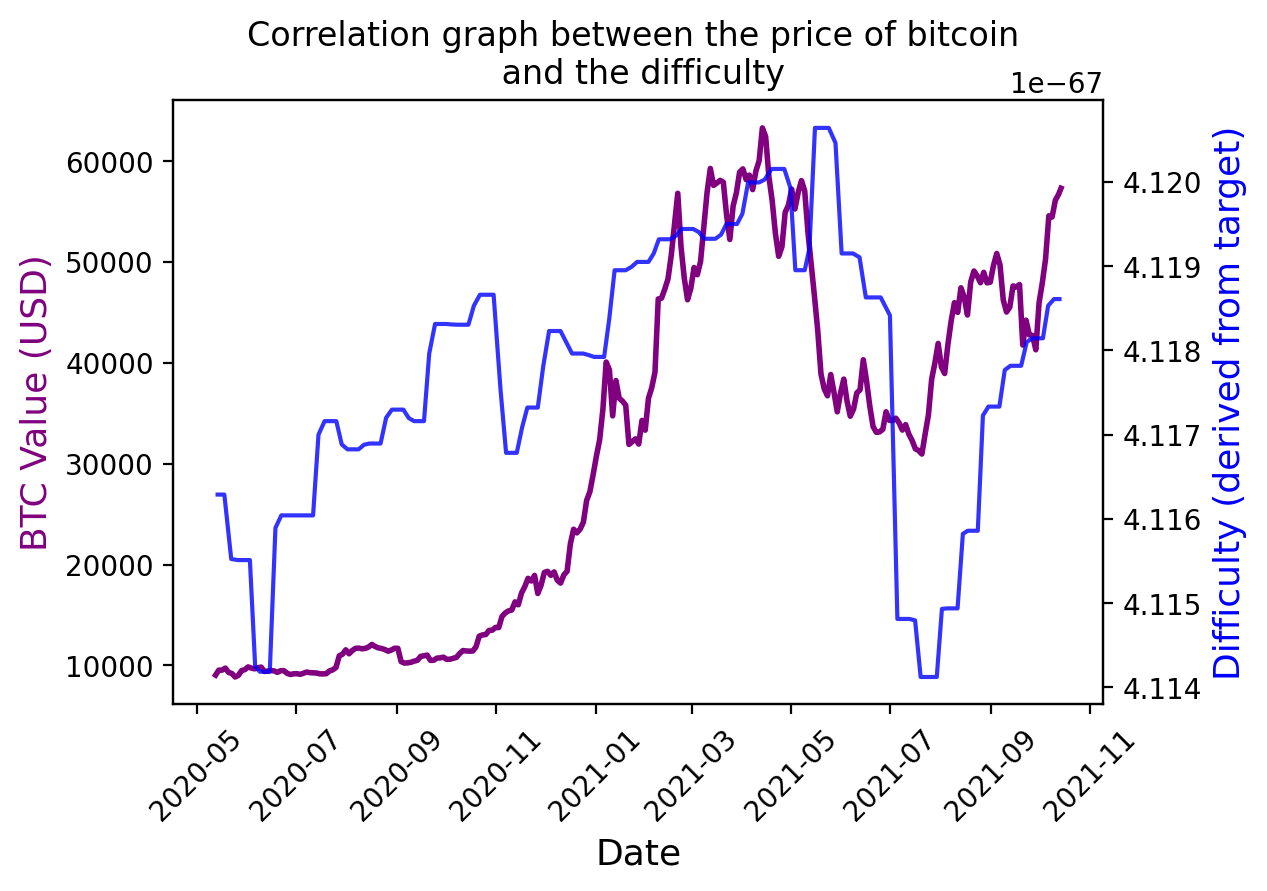

In [11]:
plot_with_financial('n_tx', title='Correlation graph between the price of bitcoin \n and the amount of transactions per block', ylabel='Amount of transactions per block')
plot_with_financial('fee', title='Correlation graph between the price of bitcoin \n and the block fee', ylabel='Block fee')
plot_with_financial('value_mean', title='Correlation graph between the price of bitcoin \n and the transaction size', ylabel='Average transaction value')
plot_with_financial('time_diff', title='Correlation graph between the price of bitcoin \n and time taken to solve a block', ylabel='Time taken to find the nonce')
plot_with_financial('value_count', title='Correlation graph between the price of bitcoin \n and the total value of the block', ylabel='Total value of the transactions')
plot_with_financial('hash', title='Correlation graph between the price of bitcoin \n and the hash of the block', ylabel='Hash of the block')
plot_with_financial('difficulty', title='Correlation graph between the price of bitcoin \n and the difficulty approximation', ylabel='Difficulty')
plot_with_financial('bits', title='Correlation graph between the price of bitcoin \n and the difficulty', ylabel='Difficulty (derived from target)')

In [21]:
# Other possible plots which were less interesting
if False:
   for col in ['ver', 'vout_sz_count', 'vout_sz_mean', 'vout_sz_std', 'fee_count', 'fee_mean', 'fee_std', 'fee_max', 'value_std']:
      plot_with_financial(col, ylabel=col)

# Comparing different parameters 

In [13]:
def plot2(col1, col2, ylabel1='', ylabel2='', title='Correlation graph'):
    grouped = block_data.groupby(np.arange(len(block_data))//500).mean()
    grouped = grouped.dropna()
    grouped['date'] = pd.to_datetime(grouped['time'], unit='s', utc=True)

    fig,ax=plt.subplots(dpi=200)
    ax.set_title(title)
    ax.set_xlabel('Date', fontsize=13)
    ax.tick_params(axis='x', labelrotation=45)

    ax.plot(grouped['date'], grouped[col1], color='blue', alpha=.8, linewidth=2)
    ax.set_ylabel(ylabel1, color='blue',fontsize=13)

    ax2=ax.twinx()
    ax2.plot(grouped['date'], grouped[col2], color='purple', alpha=.8, linewidth=2)
    ax2.set_ylabel(ylabel2, color='purple',fontsize=13)

    plt.show()

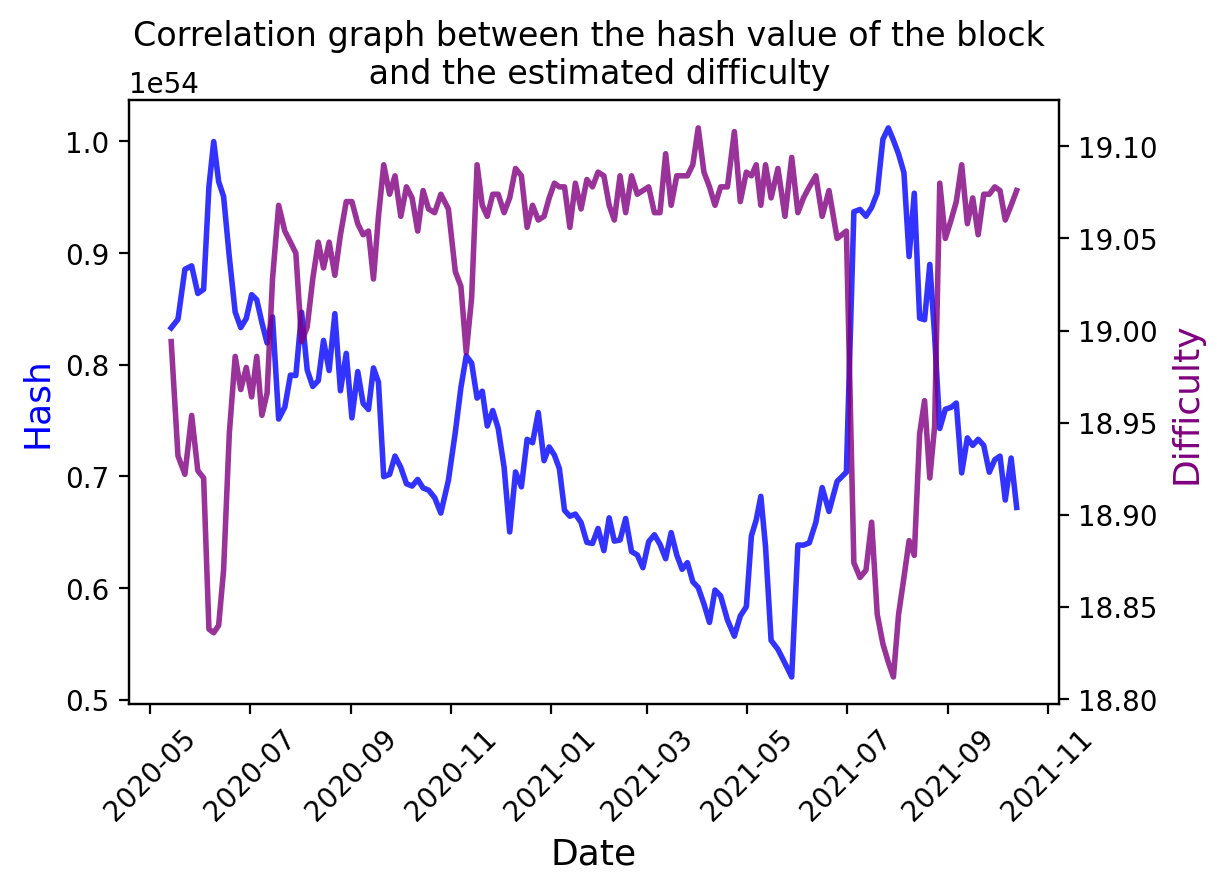

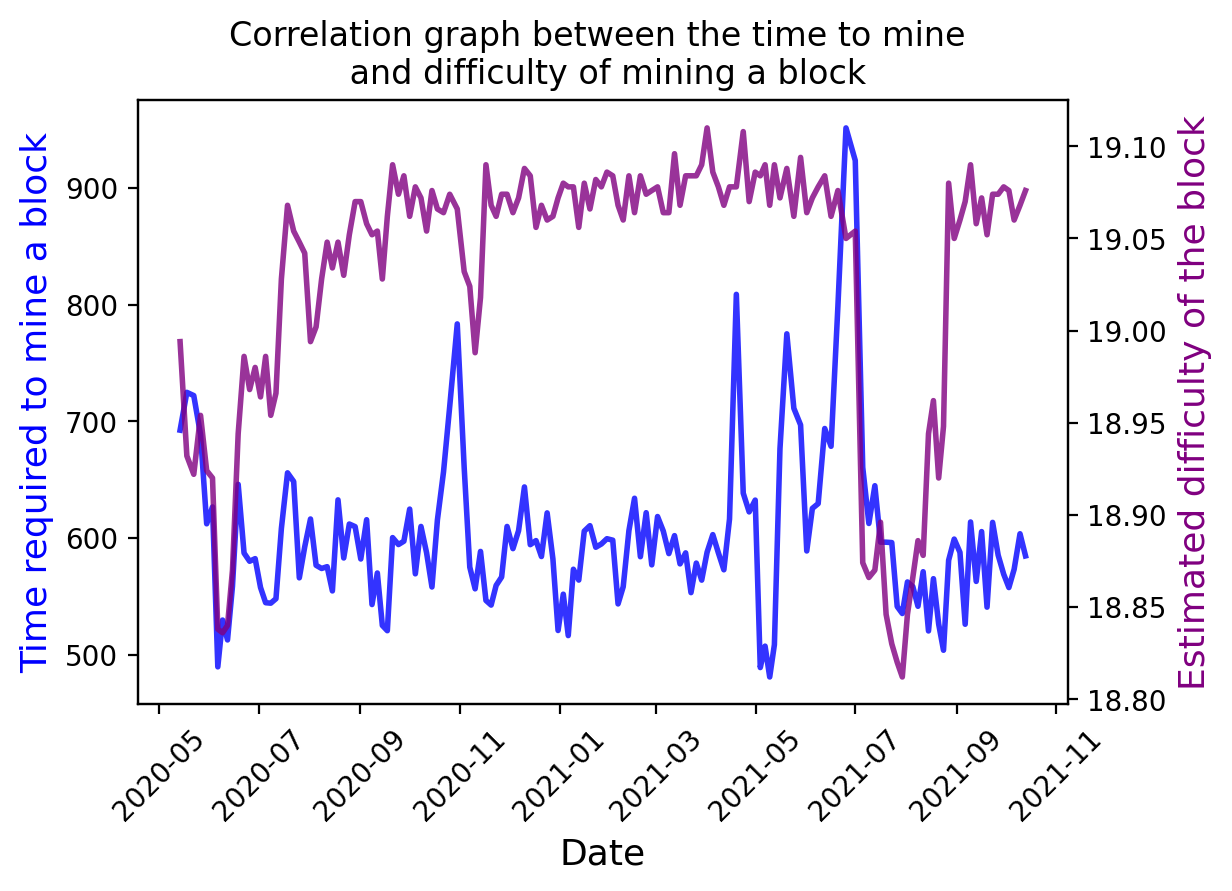

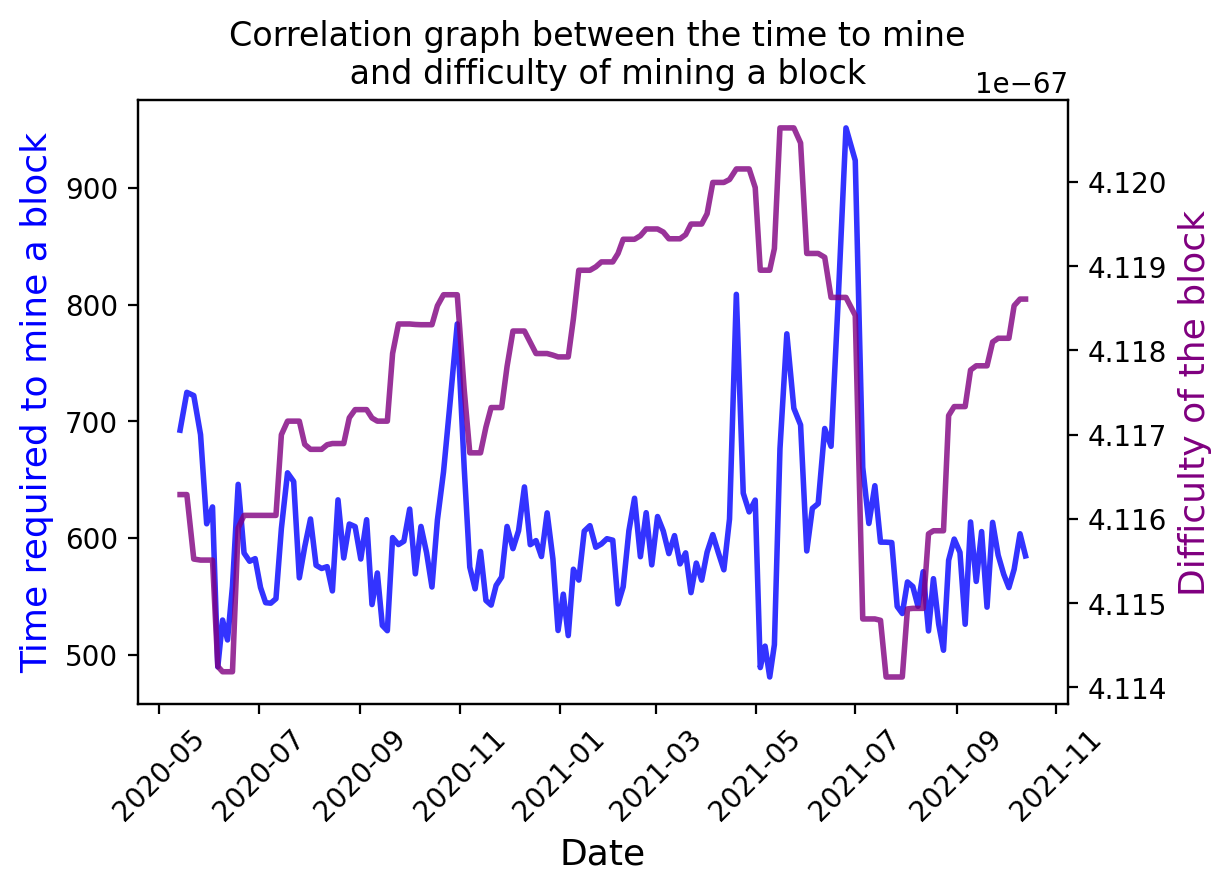

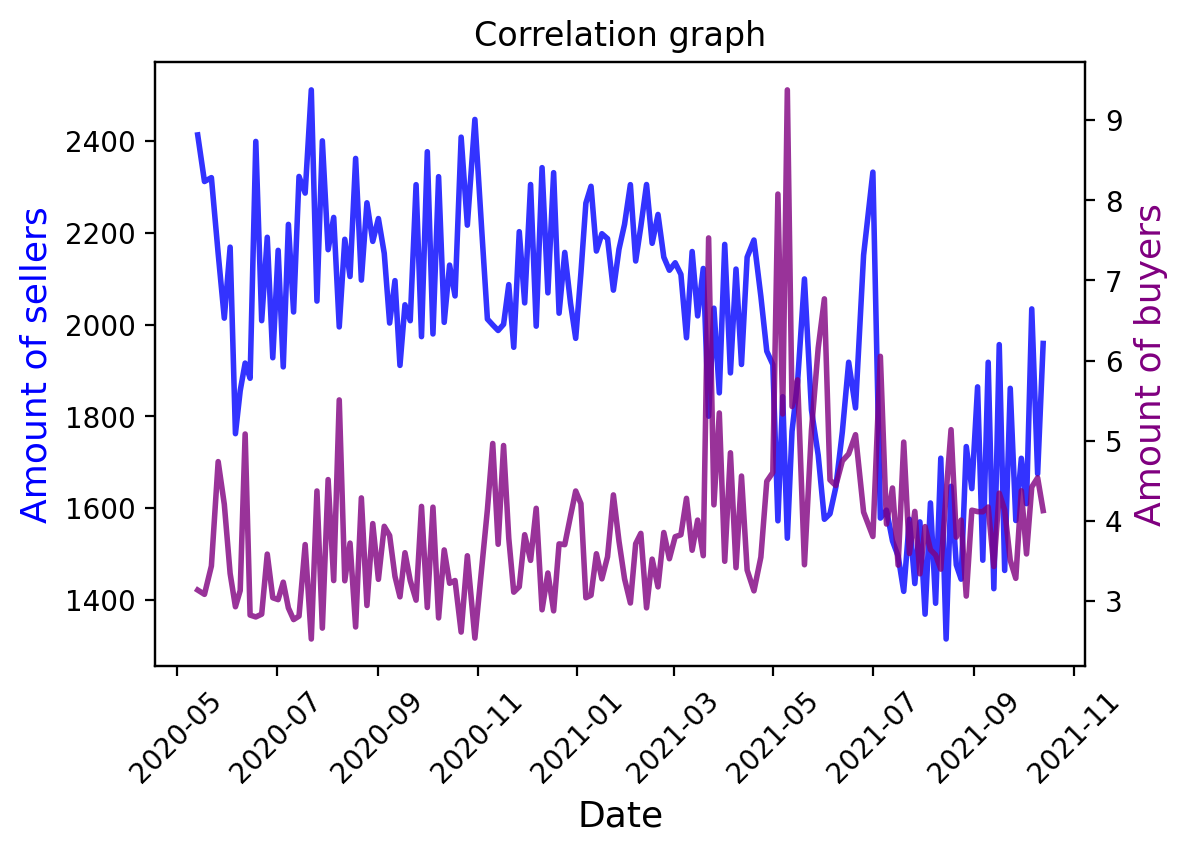

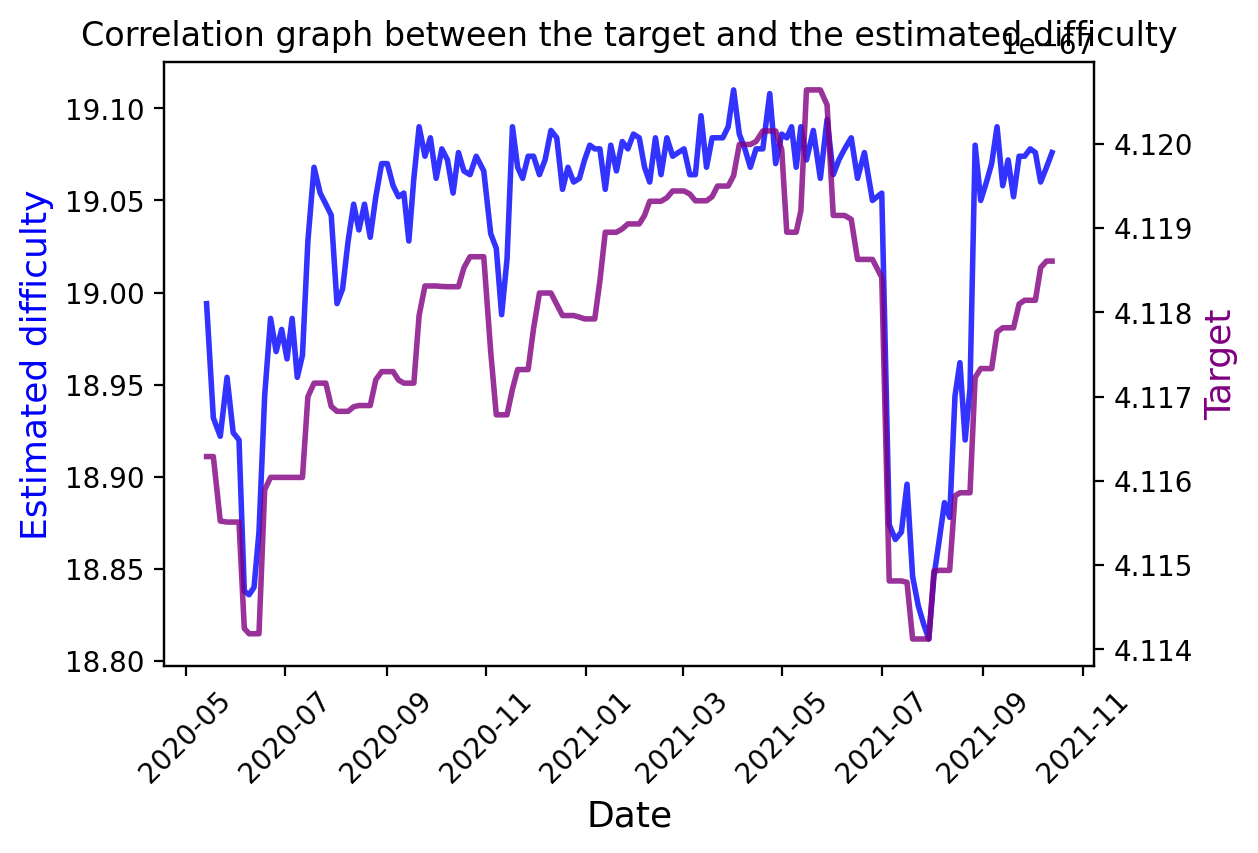

In [23]:
plot2('hash', 'difficulty','Hash', 'Difficulty', 'Correlation graph between the hash value of the block \n and the estimated difficulty')
plot2('time_diff', 'difficulty','Time required to mine a block', 'Estimated difficulty of the block', 'Correlation graph between the time to mine \n and difficulty of mining a block')
plot2('time_diff', 'bits','Time required to mine a block', 'Difficulty of the block', 'Correlation graph between the time to mine \n and difficulty of mining a block')
plot2('vin_sz_count', 'vout_sz_count','Amount of sellers', 'Amount of buyers')
plot2('difficulty', 'bits', 'Estimated difficulty', 'Target', 'Correlation graph between the target and the estimated difficulty')